In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from astropy.cosmology import Flatw0waCDM
import astropy.units as u
import emcee
import corner
dat=np.loadtxt('Shear_Ratio.dat', unpack=True)
thetas=dat[0]
zsps=dat[1]
nsp=dat[2]
ztomos=dat[3]
ntm=dat[4]
gt_ratio=dat[5]
gterr_ratio=dat[6]

In [12]:
# Set fixed cosmological parameters
from astropy.cosmology import Planck18
Om0=Planck18.Om0
Tcmb=Planck18.Tcmb0.value
Ob0=Planck18.Ob0
Neff=Planck18.Neff
H0=Planck18.H0.value
print(Planck18)

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)


In [13]:
# Load n(z) for both lens and source catalogs
nofz_lens=[]
for i in range(1,6):
    dat=np.loadtxt('LENSCATS/BOSS_data/nofz_cat_5Z_'+str(i)+'.dat',unpack=True, comments='#')
    nofz_lens.append(dat)
nofz_lens=np.array(nofz_lens)
print(nofz_lens.shape)
nofz_source=[]
for i in range(1,6):
    dat=np.loadtxt('SOURCECATS/SOM_NofZ/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO'+str(i)+'_Nz_OutlierPeaksInBins12345.asc',unpack=True, comments='#')
    nofz_source.append(dat)
nofz_source=np.array(nofz_source)
print(nofz_source.shape)

(5, 2, 120)
(5, 2, 120)


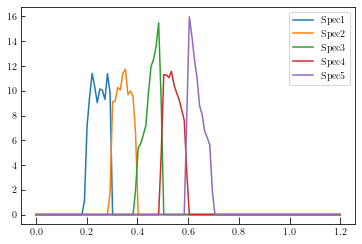

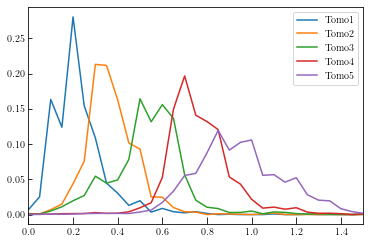

In [14]:
for i in range(5):
    plt.plot(nofz_lens[i][0],nofz_lens[i][1],label='Spec'+str(i+1))
plt.legend()
plt.show()
for i in range(5):
    plt.plot(nofz_source[i][0],nofz_source[i][1],label='Tomo'+str(i+1))
plt.xlim(0,1.5)
plt.legend()
plt.show()

In [15]:
def cal_beta(cosmo,itomo,ispec):
    beta=0
    
    for i in range(len(nofz_lens[ispec][0])):
        if nofz_lens[ispec][1][i]<1e-4:
            continue
        else:
            zl=nofz_lens[ispec][0][i]
            nofzl=nofz_lens[ispec][1][i]
            ix1=nofz_source[itomo][0]>zl
            ix2=nofz_source[itomo][0]>1e-4
            idx=ix1&ix2
            zs=nofz_source[itomo][0][idx]
            nofzs=nofz_source[itomo][1][idx]
            

            Dls=cosmo.angular_diameter_distance_z1z2(zl,zs).to(u.Mpc).value
            Ds=cosmo.angular_diameter_distance(zs).to(u.Mpc).value
            rD=Dls/Ds
            inte=nofzs*rD
            tmp=inte.sum()/nofzs.sum()
            beta=beta+nofzl*tmp
    return beta/nofz_lens[ispec][1].sum()


In [30]:
def lnlike(theta,ratio,err,nspec,ntomo):
    w0,wa = theta
    cosmo=Flatw0waCDM(H0=H0,Om0=Om0,w0=w0,wa=wa,Tcmb0=Tcmb,Neff=Neff,Ob0=Ob0)
    diff=0
    for i in range(nspec):
        beta_i4=cal_beta(cosmo,4,i)
        for j in range(ntomo-1):
            beta_ij=cal_beta(cosmo,j,i)
            model=beta_ij/beta_i4
            ix1=ntm==j
            ix2=nsp==i
            idx=ix1&ix2
            
            signal=ratio[idx]
            error=err[idx]
            invers= 1/(error.mean()**2+signal.std()**2)
            tmpdiff=-0.5*(model-signal.mean())**2*invers
            diff=diff+tmpdiff.sum()
    return diff
def lnprior(theta):
    w0,wa = theta
    if -2.0<w0<2.0 and -1.0<wa<1.0:
        return 0.0
    return -np.inf
def lnprob(theta,ratio,err,nspec,ntomo):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnlike(theta,ratio,err,nspec,ntomo)

In [31]:
w0,wa = -1,0
cosmo=Flatw0waCDM(H0=H0,Om0=Om0,w0=w0,wa=wa,Tcmb0=Tcmb,Neff=Neff,Ob0=Ob0)
print(cal_beta(cosmo,0,0))

0.24872408507342791


In [32]:
pars = np.array([-1.0,0])

ndim,nwalkers= 2,50
pos          = [pars+1e-3*np.random.randn(ndim) for i in range(nwalkers)]  
sampler      = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(gt_ratio,gterr_ratio,5,5),threads=20) 
sampler.run_mcmc(pos,500)
burnin       = 20
samples=sampler.chain[:,burnin:,:].reshape((-1,ndim))
w0,wa  = map(lambda v:(v[1],v[2]-v[1],v[1]-v[0]),zip(*np.percentile(samples,[16,50,84],axis=0)))
print('w0:',w0)
print('wa:',wa)

w0: (-0.18966525914131527, 1.1593021333112965, 1.0738302203894217)
wa: (-0.0697634252688013, 0.7095894190981867, 0.6288078972568316)


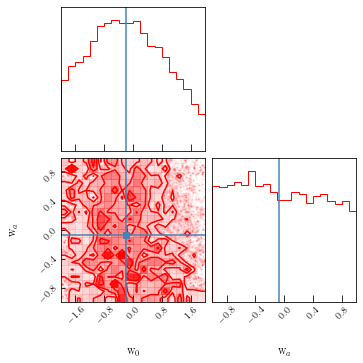

In [33]:
fig = corner.corner(samples,labels=[r"$\mathrm{w}_0$",r"$\mathrm{w}_a$"],\
        truths=[w0[0],wa[0]],color='r',\
        plot_datapoints=True,plot_density=True)
plt.show()

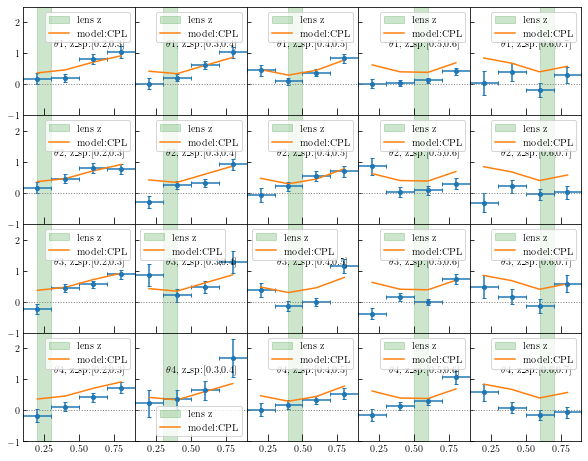

In [37]:
cosmodel=Flatw0waCDM(H0=H0,Om0=Om0,w0=w0[0],wa=wa[0],Tcmb0=Tcmb,Neff=Neff,Ob0=Ob0)
ntheta=4
ntomo=5
nspecz=5
fig=plt.figure(figsize=(10,8))
axs = fig.subplots(nrows=ntheta, ncols=nspecz, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
dat=open('Shear_Ratio_model_CPL.dat','w+')
ztomo=[0.2,0.4,0.6,0.8,1.05]
zsp=[0.2,0.3,0.4,0.5,0.6,0.7]
ztomoerr=[0.1,0.1,0.1,0.1,0.15]
ydense=np.linspace(-1,2.5,100)
for i in range(nspecz):
    for j in range(ntheta):
        minplt=i*(ntomo-1)*ntheta+ j*(ntomo-1)
        maxplt=minplt + (ntomo-1)
        tmp_axs = axs[j,i]
        tmp_axs.errorbar(ztomo[:4], gt_ratio[minplt:maxplt], xerr=ztomoerr[:4],yerr=gterr_ratio[minplt:maxplt], fmt='o', capsize=2, markersize=4.)
        tmp_axs.fill_betweenx(ydense, zsp[i],zsp[i+1],color='green',alpha=0.2,label='lens z')
        tmp_axs.set_xlim(0.1,0.9)
        tmp_axs.set_ylim(-1,2.5)

        model=np.zeros(ntomo-1)
        beta4i=cal_beta(cosmodel,4,i)
        for k in range(5-1):
            betaki=cal_beta(cosmodel,k,i)
            modelk=betaki/beta4i
            model[k]=modelk
            print(thetas[minplt+k],zsps[minplt+k],nsp[minplt+k],ztomos[minplt+k],ntm[minplt+k],gt_ratio[minplt+k],gterr_ratio[minplt+k],modelk,file=dat)
        tmp_axs.plot(ztomo[:4],model,label='model:CPL')
        tmp_axs.text(ztomo[1]*0.8, 1.2, r"$\theta$"+str(j+1)+", z_sp:["+str(zsp[i])+','+str(zsp[i+1])+']')

        tmp_axs.axhline(0., color='gray', linestyle=':', linewidth=1.)
        tmp_axs.legend()
plt.show()